In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

In [2]:
# Read a file using pandas
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/Nat_Cat_Exercise/Events.csv'
df = pd.read_csv(path)

In [4]:
df = df.dropna(subset=['title'])

In [5]:
# Drop exact duplicate clean titles
df = df.drop_duplicates(subset='title', keep='first').reset_index(drop=True)
print("New shape after deduplication:", df.shape)

New shape after deduplication: (65158, 8)


In [6]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
!pip install geonamescache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 10.8 MB/s eta 0:00:00


In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [9]:
# 4. Clean Titles
import re
def clean_title(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_title'] = df['title'].astype(str).apply(clean_title)

In [10]:
import spacy
import geonamescache

# Load spaCy model
#nlp = spacy.load("en_core_web_sm")

# Load GeoNames country and city names
gc = geonamescache.GeonamesCache()
countries = set([c['name'] for c in gc.get_countries().values()])
cities = set([c['name'] for c in gc.get_cities().values()])
gazetteer = countries.union(cities)

# Function to check if a title has a real location
def has_location(text):
    doc = nlp(text)

    # Rule 1: spaCy NER match with gazetteer
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC", "FAC"]:
            if ent.text.strip().title() in gazetteer:
                return True

    # Rule 2: Token-level backup match
    tokens = [t.text.strip().title() for t in doc if t.is_alpha]
    if any(tok in gazetteer for tok in tokens):
        return True

    return False


In [11]:
# 6. Detect Nat-Cat Keyword
CATEGORY_KEYWORDS = {
    'Earthquakes': [
        'earthquake', 'tremor', 'seismic', 'quake', 'aftershock', 'foreshock',
        'seism', 'epicenter', 'hypocenter', 'magnitude', 'richter scale',
        'seismic waves', 'ground shaking', 'fault line', 'tectonic', 'liquefaction',
        'seismograph', 'seismology', 'earth movement', 'earth vibration'
    ],

    'Hurricanes': [
        'hurricane', 'typhoon', 'cyclone', 'tropical storm', 'storm surge',
        'eye wall', 'rain bands', 'wind speed', 'category storm', 'tropical depression',
        'gale', 'tempest', 'monsoon', 'low pressure', 'storm system', 'hurricane warning',
        'hurricane watch', 'storm track', 'landfall', 'saffir-simpson'
    ],

    'Tornadoes': [
        'tornado', 'twister', 'funnel cloud', 'whirlwind', 'supercell',
        'mesocyclone', 'vortex', 'windstorm', 'tornado warning', 'tornado watch',
        'tornado siren', 'debris cloud', 'tornado alley', 'rotation', 'wall cloud',
        'hook echo', 'doppler radar', 'fujita scale', 'enhanced fujita', 'tornado outbreak'
    ],

    'Floods': [
        'flood', 'flooding', 'inundation', 'deluge', 'flash flood',
        'torrent', 'high water', 'overflow', 'submersion', 'waterlogging',
        'floodwaters', 'flood damage', 'flood alert', 'flood warning', 'flood watch',
        'levee breach', 'dam break', 'runoff', 'water rise', 'coastal flooding'
    ],

    'Wildfires': [
        'wildfire', 'bushfire', 'forest fire', 'brush fire', 'grass fire',
        'wildland fire', 'firestorm', 'conflagration', 'ember', 'fire spread',
        'fire line', 'fire suppression', 'fire evacuation', 'smoke plume', 'fire season',
        'fire danger', 'red flag warning', 'backfire', 'firebreak', 'containment line'
    ],

    'Tsunamis': [
        'tsunami', 'tidal wave', 'seismic wave', 'harbor wave', 'ocean surge',
        'coastal flooding', 'wave height', 'run-up', 'tsunami warning', 'tsunami alert',
        'tidal bore', 'tsunami advisory', 'seiche', 'displacement wave', 'tsunami siren',
        'tsunami evacuation', 'tsunami zone', 'tsunami buoys', 'megatsunami', 'tsunami ready'
    ],

    'Volcanic eruptions': [
        'volcano', 'eruption', 'lava', 'magma', 'ash cloud',
        'pyroclastic', 'volcanic ash', 'crater', 'caldera', 'fumarole',
        'geyser', 'volcanic gas', 'tephra', 'lahar', 'volcanic bomb',
        'pumice', 'volcanic winter', 'vog', 'volcano alert', 'volcanic explosivity index'
    ]
}
def is_natcat_event(title):
    title = title.lower()
    has_event = any(kw in title for kws in CATEGORY_KEYWORDS.values() for kw in kws)
    return has_event and has_location(title)

df['is_natcat'] = df['clean_title'].apply(is_natcat_event)

In [12]:
# 7. Filter
df_natcat = df[df['is_natcat'] == True].copy()
print("Filtered shape:", df_natcat.shape)

Filtered shape: (21570, 10)


In [13]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [19]:
from keybert import KeyBERT
from collections import defaultdict

In [20]:
CATEGORY_KEYWORDS = {
    'Earthquakes': ['earthquake', 'tremor', 'seismic', 'quake','tsunami', 'tidal wave', 'seismic wave'],
    'Floods': ['flood', 'flooding', 'inundation'],
    'Volcanic eruptions': ['volcano', 'eruption', 'lava'],
    'Tornadoes': ['tornado', 'twister', 'cyclone','hurricane', 'typhoon', 'cyclone'],
    'Wildfires': ['wildfire', 'bushfire', 'forest fire'],

}

In [21]:
kw_model = KeyBERT()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [22]:
def classify_disaster(title, threshold=0.3):
    # Extract keywords
    keywords = kw_model.extract_keywords(
        title,
        keyphrase_ngram_range=(1, 2),
        stop_words='english',
        top_n=5
    )

    # Filter keywords by score
    filtered_keywords = [kw for kw, score in keywords if score >= threshold]

    # Calculate category scores
    category_scores = defaultdict(int)
    for category, terms in CATEGORY_KEYWORDS.items():
        for term in terms:
            if any(term in kw.lower() for kw in filtered_keywords):
                category_scores[category] += 1

    # Determine predicted category
    predicted_category = max(category_scores.items(), key=lambda x: x[1])[0] if category_scores else "Unknown"

    return predicted_category, filtered_keywords

In [23]:
# Apply classification to each title
df_natcat['predicted_category'] = df_natcat['title'].apply(classify_disaster)

In [24]:
df_natcat.reset_index(drop=True, inplace=True)

In [25]:
df_natcat.shape

(21570, 11)

In [26]:
df_natcat['key_Bert'] = df_natcat['predicted_category'].apply(lambda x: x[0])

In [39]:
df_natcat.key_Bert.value_counts()

,count
key_Bert,
Earthquakes,6271
Floods,4708
Tornadoes,4417
Wildfires,3351
Volcanic eruptions,1595
Unknown,1228


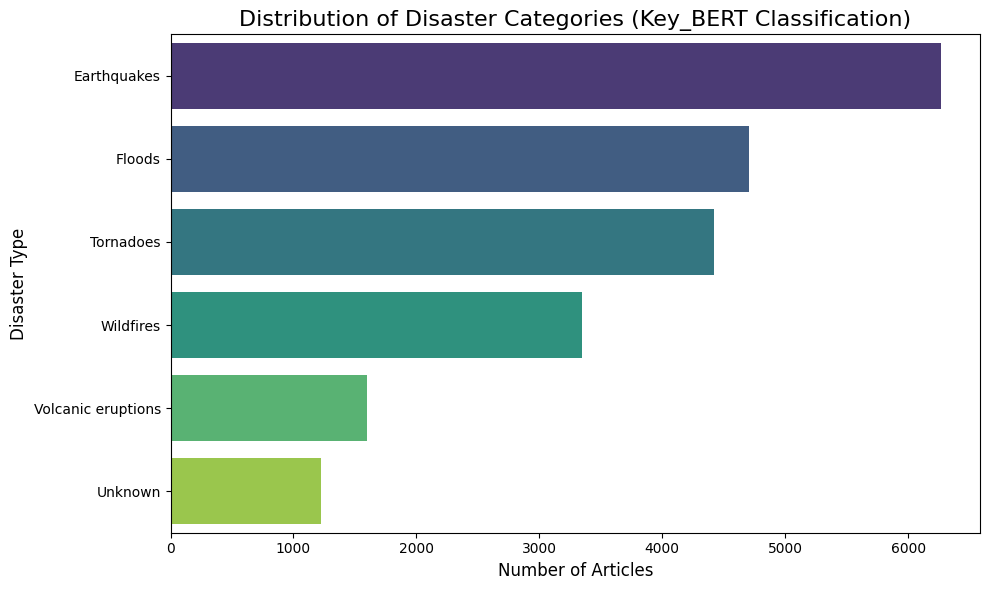

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_natcat, y='key_Bert', order=df_natcat['key_Bert'].value_counts().index, palette='viridis')

plt.title('Distribution of Disaster Categories (Key_BERT Classification)', fontsize=16)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Disaster Type', fontsize=12)

plt.tight_layout()
plt.show()

In [28]:
def test_classify_disaster():
    """Simple test cases for classify_disaster function"""

    # Example 1: Clear natural disaster
    title = "Major earthquake hits California"
    category, keywords = classify_disaster(title)
    print(f"Test 1 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")
    print()

    # Example 2: Industrial accident
    title = "Chemical plant explosion in Texas"
    category, keywords = classify_disaster(title)
    print(f"Test 2 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")
    print()

    # Example 3: Below threshold (should return Unknown)
    title = "Minor incident at local factory"
    category, keywords = classify_disaster(title, threshold=0.5)
    print(f"Test 3 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")
    print()

    # Example 4: No matching category
    title = "Celebrity wedding announcement"
    category, keywords = classify_disaster(title)
    print(f"Test 4 - '{title}':")
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords}")

# Run the tests
if __name__ == "__main__":
    test_classify_disaster()

Test 1 - 'Major earthquake hits California':
  Category: Earthquakes
  Keywords: ['earthquake hits', 'major earthquake', 'hits california', 'earthquake', 'california']

Test 2 - 'Chemical plant explosion in Texas':
  Category: Unknown
  Keywords: ['explosion texas', 'plant explosion', 'explosion', 'chemical plant', 'chemical']

Test 3 - 'Minor incident at local factory':
  Category: Unknown
  Keywords: ['incident local', 'minor incident', 'incident', 'local factory', 'factory']

Test 4 - 'Celebrity wedding announcement':
  Category: Unknown
  Keywords: ['celebrity wedding', 'wedding announcement', 'wedding', 'celebrity', 'announcement']


In [29]:
!pip install bertopic
from bertopic import BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.1/153.1 kB 3.9 MB/s eta 0:00:00


In [30]:
from bertopic import BERTopic
import pandas as pd

# Fit BERTopic
topic_model = BERTopic(language="english", nr_topics=5)
topics, probs = topic_model.fit_transform(df_natcat['clean_title'])

# STEP 1: Display topic keywords for manual inspection
print("Topic Keywords:")
for topic_num in set(topics):
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}")

# STEP 2: Manually map topics to your 5 disaster categories
# After inspecting above output, update this dictionary accordingly
manual_topic_map = {
    0: "Earthquake",
    1: "Tornado",
    2: "Volcano",
    3: "Floods",
    4: "Wildfire"
}

# STEP 3: Create DataFrame with results
df_result = pd.DataFrame({
    "title": df_natcat['clean_title'],
    "topic_num": topics,
    "topic_label": [manual_topic_map.get(t, "Unknown") for t in topics]
})

print("\nFinal Categorized Titles:")
#print(df)


Topic Keywords:
Topic 0: [('in', np.float64(0.06128919323759798)), ('of', np.float64(0.058449595210062565)), ('to', np.float64(0.05387720280054744)), ('wildfire', np.float64(0.052012986937257234)), ('flood', np.float64(0.05159268670412977)), ('tornado', np.float64(0.04841445401897965)), ('for', np.float64(0.04238969954800831)), ('as', np.float64(0.039487143961584405)), ('hurricane', np.float64(0.03859564017717427)), ('the', np.float64(0.03374207497439929))]
Topic 1: [('earthquake', np.float64(0.14271709877248812)), ('magnitude', np.float64(0.07222077463121375)), ('in', np.float64(0.07206464713355129)), ('mag', np.float64(0.06652411784376099)), ('near', np.float64(0.06245374179280091)), ('of', np.float64(0.061618200724801966)), ('light', np.float64(0.059240296326127366)), ('volcano', np.float64(0.05671741753787143)), ('quake', np.float64(0.05631714410471651)), ('japan', np.float64(0.047678866678125584))]
Topic 2: [('twisters', np.float64(0.22734965606714547)), ('twister', np.float64(0.2

In [31]:
df_result.head()

,title,topic_num,topic_label
0,Iceland volcanoes bring tourists to island cou...,1,Tornado
1,Tornados scorchers and ice storm Top 10 weathe...,0,Earthquake
2,Yellowstone Supervolcano Magma Chamber Is Very...,1,Tornado
3,Japan earthquakes Coastal residents told to ev...,1,Tornado
4,Topic Tsunami The Sydney Morning Herald,1,Tornado


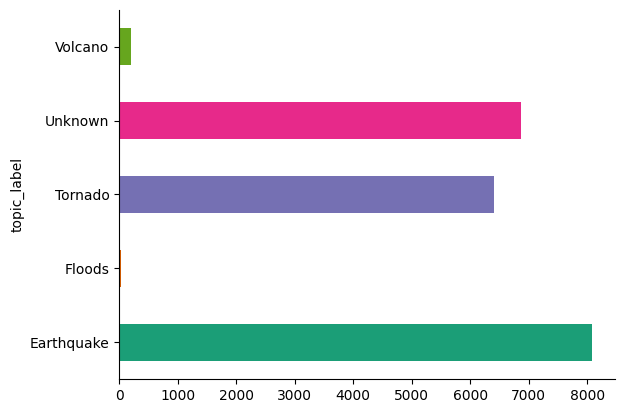

In [37]:
# @title topic_label

from matplotlib import pyplot as plt
import seaborn as sns
df_result.groupby('topic_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [32]:
df_result.topic_label.value_counts()

,count
topic_label,
Earthquake,8075
Unknown,6863
Tornado,6408
Volcano,199
Floods,25


In [36]:
# Sample random titles from each topic for manual review
sample_size = 20  # Number of samples to check per topic

for topic_label in manual_topic_map.values():
    print(f"\n=== Samples for {topic_label} ===")
    topic_df = df_result[df_result['topic_label'] == topic_label]
    if not topic_df.empty:
        n_samples = min(sample_size, len(topic_df))
        sample_titles = topic_df.sample(n_samples)['title']
        for title in sample_titles:
            print(f"- {title}")
    else:
        print("No titles found for this topic.")
    print(f"\nEstimated accuracy for {topic_label}: [your estimate]% correct")


=== Samples for Earthquake ===
- New wildfire burning near west end of Kamloops Lake Kamloops News
- Today weather Chicago Severe weather looms with chances for hail tornado with hail tornado NBC Chicago
- A Tornado Watch is Now In Effect for Much of Deep East Texas
- Flash Flood Watch Issued for the City of Wilmington
- Alberta premier moved to tears by wildfire damage in Jasper despite climate change denial
- Wiltshire and Swindon flooding possible from heavy rain
- Wildfire awareness education and preparation to be addressed at Carson City workshop
- EPA completes 17 miles of sewer line inspection continues sampling drinking water lines impacted by Maui wildfires Maui Now
- A warm dry spring has U S forecasters worried about the upcoming wildfire season
- The Noxious Cocktail of Wildfire Smoke
- Firefighters check expansion of Boxford State Forest wildfire
- What to expect in Southwest Florida as Hurricane Helene strengthens makes landfall
- Aerial photos show wide devastation left